In [1]:
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
from warnings import simplefilter

from os import path
from confer_wp3.dataloading import load_raw_data, save_anomalies, save_eofs_pcs, save_model_results
from confer_wp3.lasso_forecast import calculate_anomalies, quantile_mapping, compute_eofs_pcs, get_all_indices, get_ml_results, calculate_tercile_probability_forecasts
from confer_wp3.plotting import plot_fields_simple

simplefilter("ignore", category=RuntimeWarning)

The following variables specify the paths where the forecast and observation data are stored, and the paths where the various calculations get stored.

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
# indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
# anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
# eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
# fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

anomaly_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/anomalies/"
eof_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/eofs_pcs/"
indices_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/indices/"
ml_dir = "/nr/samba/user/ahellevik/CONFER-WP3/validation_data/ml_data/"

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]



### Needed?
n_eofs = 7 # Number of EOFs to compute

### CHIRPS Data

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loadings, and save out. Otherwise, load anomalies, EOFs and factor loadings.

##### Loading data

In [4]:
# Load data
year, lat, lon, prec_data = load_raw_data(chirps_dir, "chirps", [*range(year_train_start, year_train_end+1)], season, lat_bnds, lon_bnds) # 1993, 2021

##### Get anomalies and normalized anomalies

In [5]:
# Get anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_{season}.nc'):
    # Calculate anomalies
    anomalies = calculate_anomalies(prec_data, year, period_clm)
    # Save anomalies
    save_anomalies(anomalies, year, lat, lon, anomaly_dir, season, normalized=False)
else:
    anomalies = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_{season}.nc', engine='netcdf4')
    anomalies = anomalies.values

In [6]:
# Get normalized anomalies
if not path.exists(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc'):
    # Apply the transformation to the anomalies data
    anomalies_normal = quantile_mapping(anomalies, year, period_clm)
    # Save normalized anomalies
    save_anomalies(anomalies_normal, year, lat, lon, anomaly_dir, season, normalized=True)
else:
    anomalies_normal = xr.open_dataarray(f'{anomaly_dir}chirps_anomalies_normal_{season}.nc', engine='netcdf4')
    anomalies_normal = anomalies_normal.values

##### Get EOFs and factor loadings

In [7]:
# Get EOFs, PCs and variance fractions
if not path.exists(f'{eof_dir}chirps_eofs_{season}.nc'):
    # Calculate EOFs
    n_eofs = 7  # Number of EOFs to compute
    eofs, pcs, var_fracs = compute_eofs_pcs(anomalies_normal, n_eofs)
    # Reshape EOFs to 3D (n_eofs, lat, lon)
    eofs_reshaped = eofs.reshape((n_eofs, len(lat), len(lon)))
    # Save EOFs, PCs and variance fractions
    save_eofs_pcs(eofs_reshaped, pcs, var_fracs, year, lat, lon, eof_dir, season)
else:
    eofs_reshaped = xr.open_dataarray(f'{eof_dir}chirps_eofs_{season}.nc', engine='netcdf4').values
    pcs = xr.open_dataarray(f'{eof_dir}chirps_pcs_{season}.nc', engine='netcdf4').values
    var_fracs = xr.open_dataarray(f'{eof_dir}chirps_var_fracs_{season}.nc', engine='netcdf4').values

### ERA5 Data

If not already available, load ERA5 data, calculate indices, and save out. Otherwise, load indices.

##### Get ERA5 indices

In [8]:
# Get era5 indices
# Define the file path
era5_indices_path = f'{indices_dir}era5_indices.nc'
# Shared between all indices
months = list(range(1, 13))

if not path.exists(era5_indices_path):
    # Load needed data
    load_years = [i for i in range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]
    # Load sst data
    sst_data = load_raw_data(era5_dir, "sst", load_years, season)
    # Load uwind200 data
    uwind200_data = load_raw_data(era5_dir, "uwind200", load_years, season)
    # Load uwind850 data
    uwind850_data = load_raw_data(era5_dir, "uwind850", load_years, season)

    # Calculate indices
    era5_indices = get_all_indices(sst_data, uwind200_data, uwind850_data, period_clm, period_train, months)
    # Save indices
    # Convert DataFrame to xarray Dataset for saving
    ds = era5_indices.set_index(['year', 'month']).to_xarray()

    # Save the Dataset to a NetCDF file
    print("Saving indices...")
    ds.to_netcdf(era5_indices_path)
    print(f"Data saved to {era5_indices_path}")
else:
    # Load the NetCDF file into an xarray Dataset
    ds_loaded = xr.open_dataset(era5_indices_path, engine='netcdf4')
    print(f"Data loaded from {era5_indices_path}")

    # Convert the xarray Dataset back to a DataFrame
    era5_indices = ds_loaded.to_dataframe().reset_index()

Data loaded from /nr/samba/user/ahellevik/CONFER-WP3/validation_data/indices/era5_indices.nc


### ML model

##### Get ML model data

In [9]:
feature_names = ['n34','dmi','wvg','wsp','wpg','wp','wnp','n34_diff1','dmi_diff1','ueq850','ueq200','sji850','sji200']

# Get model coefficients and covariances, or train model
if not path.exists(f'{ml_dir}model_coefficients_{season}.nc'):
    df_coefficients, df_fl_pred_cov = get_ml_results(era5_indices, feature_names, pcs, var_fracs, n_eofs, period_train, period_clm, month_init)
    save_model_results(df_coefficients, df_fl_pred_cov, ml_dir, season)
else:
    df_coefficients = xr.load_dataset(f'{ml_dir}model_coefficients_{season}.nc').to_dataframe()
    
    cov_ds = xr.load_dataset(f'{ml_dir}prediction_covariances_{season}.nc')
    cov_array = cov_ds.covariance.values
    years = cov_ds.year.values
    n_eofs = cov_array.shape[1]
    
    # Reconstruct df_fl_pred_cov
    df_fl_pred_cov = pd.DataFrame(
        index=years,
        columns=[f'cov-{i}{j}' for i in range(1, n_eofs + 1) for j in range(1, n_eofs + 1)],
        data=cov_array.reshape(len(years), -1)
    )

### Forecast

Make a forecast for the specified year and season

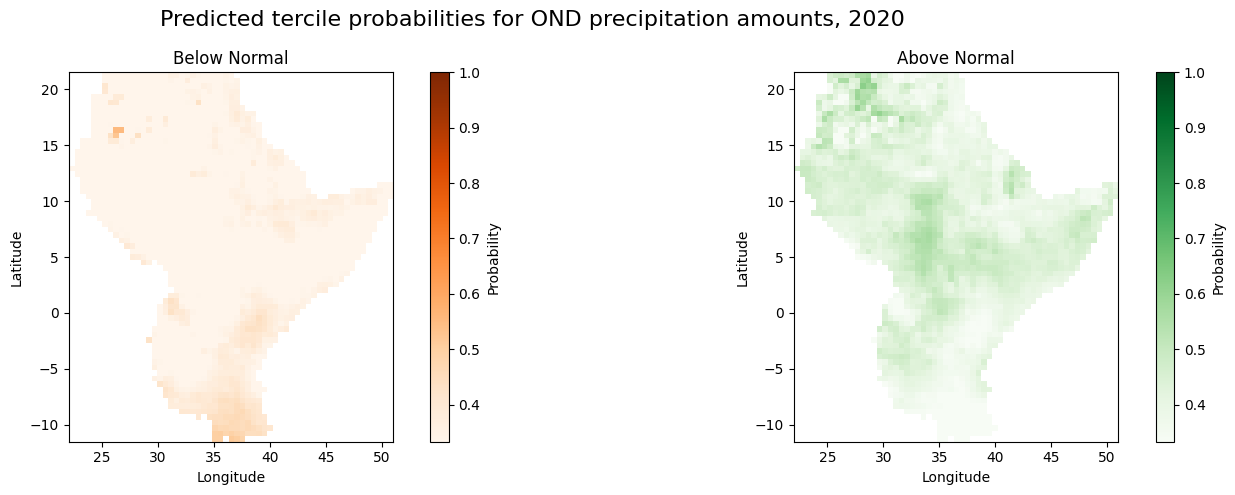

In [10]:
# Get tercile probability forecasts
prob_bn, prob_an = calculate_tercile_probability_forecasts(era5_indices, anomalies_normal, eofs_reshaped, df_coefficients, df_fl_pred_cov, var_fracs, feature_names, year, period_clm, n_eofs, year_fcst, month_init)

# Plot the probabilities
plot_fields_simple(fields=[prob_bn, prob_an],
            titles=['Below Normal', 'Above Normal'],
            cmap=['Oranges', 'Greens'],
            unit='Probability',
            lat = lat,
            lon = lon,
            season=season,
            year=year_fcst)

